In [192]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt
import sounddevice as sd
from scipy import signal
import pandas as pd


In [171]:
# Helper function to generating a Waveforms
def genLinearChirpWave(mag = 1,frequencies = (200,400),dur = 1,sr = 10000):
    dt        = 1/sr
    ts        = np.arange(-dt,dur+dt,dt)

    freqrange = np.linspace(frequencies[0],frequencies[1],len(ts))
    dps   = (2*np.pi*freqrange*dt)
    phases = np.cumsum(dps)
    return mag*np.cos(phases),ts

def genExpoChirpWave(mag = 1,frequencies = (200,400),dur = 1,sr = 10000):
    dt        = 1/sr
    ts        = np.arange(-dt,dur+dt,dt)

    freqrange = np.logspace(np.log10(frequencies[0]),np.log10(frequencies[1]),len(ts))
    dps   = (2*np.pi*freqrange*dt)
    phases = np.cumsum(dps)
    return mag*np.cos(phases),ts

def genSineWave(amp = 1,freq = 1,off = 0,dur = 1,frate = 10000):
    dt        = 1/frate
    ts = np.arange(0,dur+dt,dt)
    t  = np.arange(0,len(ts))
    return amp*np.sin((2*np.pi*freq*t/frate)+off),ts

# Helper Function for converting waves to fft power spectrums back and forth
def make_spectrum(datain, ratein):
    n = len(datain)
   # d = 1 ./ ratein  # timestep
    # power spectral density
    hsout = np.fft.rfft(datain)
    # frequency spectrum
    freq = np.fft.rfftfreq(n, d=1./ratein)
    return hsout, freq

def make_wave(hsin):
    wave = np.fft.irfft(hsin)
    return wave

def make_spectrogram(wave,ts,seg_length,frate = 10000):
        window = np.hamming(seg_length)
        i, j = 0, seg_length
        step = int(seg_length / 2)
        spec_map = {}
        
        while j < len(wave):
            segment = wave[i:j].copy()
        
            t = (ts[i] + ts[j]) / 2
            spec_map[t],freq = make_spectrum(segment,frate)
            i += step
            j += step
        return spec_map,freq

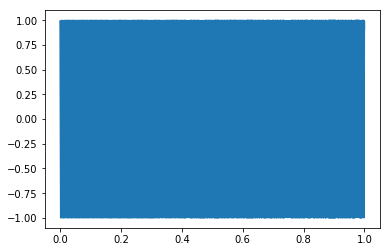

Note that phase is the integral of the frequency


In [128]:
## Generate a Chirp
# Signal specs
amp1  = 1  # Amplitude (V)
freqrange = (220,440)   # frequency (hz)
dur1  = 1   # duration (s)
# Generate Linear Chirp Wave
wave,ts = genLinearChirpWave(mag = amp1,dur = dur1,frequencies = freqrange)
plt.plot(ts,wave)
plt.show()
# Normalize wave to make it audio friendly
wav_wave = wave / np.max(np.abs(wave))
wav_wave = np.array(wav_wave, dtype=np.float)
sd.play(wave,10000,blocking=True)
print("Note that phase is the integral of the frequency")

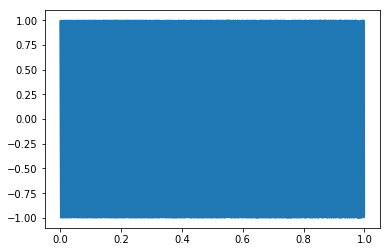

Note that the perceived pitch increases exponentially
Because the octave range increases by a power of 2
Example--> Octave range 1: (220,440), Octave range 2: (440,880)


In [129]:
# Generate Exponential Chirp Wave
wave2,ts2 = genExpoChirpWave(mag = amp1,dur = dur1,frequencies = freqrange)
plt.plot(ts2,wave2)
plt.show()
# Normalize wave to make it audio friendly
wav_wave = wave2 / np.max(np.abs(wave2))
wav_wave = np.array(wav_wave, dtype=np.float)
sd.play(wav_wave,10000,blocking=True)
print("Note that the perceived pitch increases exponentially")
print("Because the octave range increases by a power of 2")
print("Example--> Octave range 1: (220,440), Octave range 2: (440,880)")

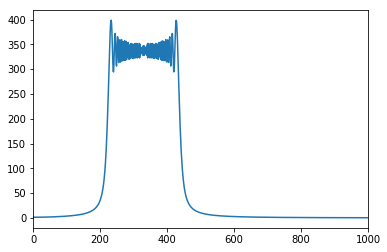

In [130]:
spec, freq = make_spectrum(wave, 10000)
plt.plot(freq,np.absolute(spec))
plt.xlim([0,1000])
plt.show()

257 38 (257, 38)
257 41 (257, 41)


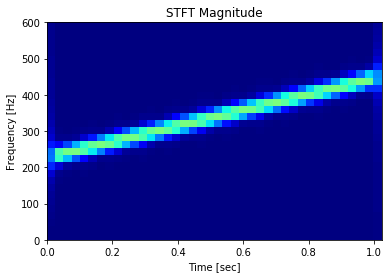

Time resolution = 0.0512 (s) [n/sr]
Frequency resolution = 19.53125 (hz) [sr/n]


In [213]:
## Generate spectrogram to visualize STFT
sr         = 10000
nsegLength = 512
# Own function call (Not working well)
spec_map,freq  = make_spectrogram(wave,ts,nsegLength,frate = sr)
spec_mat = np.array(pd.DataFrame.from_dict(spec_map))
spec_ts  = list(spec_map.keys())
print(len(freq),len(spec_ts),spec_mat.shape)
# Using the scipy library
f, t, Zxx = signal.stft(wave, sr, nperseg=nsegLength)
print(len(f),len(t),Zxx.shape)
plt.pcolormesh(t, f, np.abs(Zxx), vmin=0, vmax=amp1,cmap='jet')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,600])
plt.show()
print("Time resolution =",nsegLength/sr,"(s) [n/sr]")
print("Frequency resolution =",sr/nsegLength,"(hz) [sr/n]")

/usr/local/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


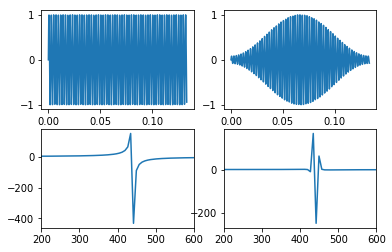

Spectral Leakage: Because DFT treats waveform as periodic. Segments that are not
multiples of the period becomes discontinuous, resulting in frequencies that 'leak'


In [167]:
## LEAKAGE
swave,sts = genSineWave(amp = 1,freq = 440,dur = 40/300,frate = 10000)
spec,fq   = make_spectrum(swave,10000)
# Using a hanning window reduces the effects of leakage
whann = np.hamming(len(swave))
hannwave = swave*whann
spec2,fq2 = make_spectrum(hannwave,10000)
plt.figure(1)
plt.subplot(221)
plt.plot(sts,swave)
plt.subplot(222)
plt.plot(sts,hannwave)
plt.subplot(223)
plt.plot(fq,spec)
plt.xlim([200,600])
plt.subplot(224)
plt.plot(fq2,spec2)
plt.xlim([200,600])
plt.show()
print("Spectral Leakage: Because DFT treats waveform as periodic. Segments that are not")
print("multiples of the period becomes discontinuous, resulting in frequencies that 'leak'")

In [253]:
# Load audio signal
datafolder = '/Users/maxmaguire/Desktop/PostGradWork/DataFolder/SampleAudioFiles/'
fname = datafolder + '87778__marcgascon7__vocals.wav'
rate, data = scipy.io.wavfile.read(fname)
sd.play(data[:,0],rate)

257 1368 (257, 1368)


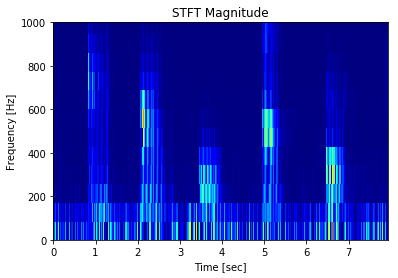

173


In [219]:
nsegLength = 512
f, t, Zxx = signal.stft(data[:,0], rate, nperseg=nsegLength)
print(len(f),len(t),Zxx.shape)
plt.pcolormesh(t, f, np.abs(Zxx),cmap='jet')
plt.title('STFT Magnitude')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.ylim([0,1000])
plt.show()

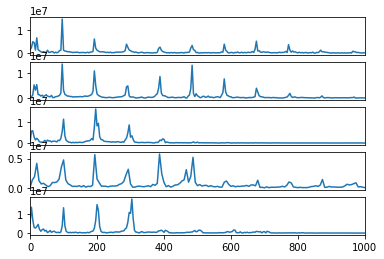

In [252]:
# Look at the spectral differences between the vowels pronounced
time = np.cumsum(np.full([1,data.shape[0]],1/rate))
time[0] = 0
lidx1 = np.all([time >= 1, time <= 1.25],axis = 0)   # AHH
lidx2 = np.all([time >= 2.2, time <= 2.45],axis = 0) # AEE
lidx3 = np.all([time >= 3.5, time <= 3.75],axis = 0) # IEE
lidx4 = np.all([time >= 5.2, time <= 5.35],axis = 0) # OHH
lidx5 = np.all([time >= 6.5, time <= 6.75],axis = 0) # UHH


spec1,fq1   = make_spectrum(data[lidx1,0].copy(),rate) 
spec2,fq2   = make_spectrum(data[lidx2,0].copy(),rate)
spec3,fq3   = make_spectrum(data[lidx3,0].copy(),rate)
spec4,fq4   = make_spectrum(data[lidx4,0].copy(),rate)
spec5,fq5   = make_spectrum(data[lidx5,0].copy(),rate)

plt.figure(1)
plt.subplot(511)
plt.plot(fq1,np.abs(spec1))
plt.xlim([0,1000])
plt.xticks([])
plt.subplot(512)
plt.plot(fq2,np.abs(spec2))
plt.xlim([0,1000])
plt.xticks([])
plt.subplot(513)
plt.plot(fq3,np.abs(spec3))
plt.xlim([0,1000])
plt.xticks([])
plt.subplot(514)
plt.plot(fq4,np.abs(spec4))
plt.xlim([0,1000])
plt.xticks([])
plt.subplot(515)
plt.plot(fq5,np.abs(spec5))
plt.xlim([0,1000])
plt.show()

